In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from commando import ComManDo
from commando.evaluation import *
from commando.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-10-10 05:48:07.491979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 05:48:07.492016: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'scGEM'
dataset_color = 'blue'
modality_names = ['Gene Expression', 'DNA Methylation']
data1 = np.loadtxt("../data/UnionCom/scGEM/GeneExpression.txt")
data2 = np.loadtxt("../data/UnionCom/scGEM/DNAmethylation.txt")
type1 = np.loadtxt("../data/UnionCom/scGEM/type1.txt")
type2 = np.loadtxt("../data/UnionCom/scGEM/type2.txt")
fnames1 = np.loadtxt("../data/UnionCom/scGEM/gex_names.txt", dtype='str')
fnames2 = np.loadtxt("../data/UnionCom/scGEM/dm_names.txt", dtype='str')
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)

# To H5
# pd.DataFrame(data1).to_hdf('../data/' + dataset_name + '.h5', 'data1')
# pd.DataFrame(data2).to_hdf('../data/' + dataset_name + '.h5', 'data2')

# Sampling
# idx = np.random.choice(range(data1.shape[0]), 50, replace=False)
# data1, data2, type1, type2 = (x[idx] for x in (data1, data2, type1, type2))

# Labels
type_func = lambda x: {1:'BJ', 2:'d8', 3:'d16T+', 4:'d24T+', 5:'IPS'}[x]
labels = [np.array([type_func(j) for j in i]) for i in (type1,type2)]
features = [fnames1, fnames2]
feature_dict = {}

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [6]:
reduced_dim = 32

# ComManDo

In [7]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 128,
    'pca_dim': None,
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
    'dropout': 0,
}
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = 'saved_models/cm---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
cm = ComManDo(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    cm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    cm_data = cm.fit_transform(dataset=dataset)
    cm.save_model(model_str)
    np.save(match_str, cm.match_result, allow_pickle=True)
cm_data = cm.transform(dataset=dataset)

Loaded model 'saved_models/cm---scGEM---177-34---177-27---batch_size-128--dist_method-euclidean--dropout-0--epoch_DNN-10000--log_DNN-500--loss_weights-(1-1-1-1)--min_epochs-2500--output_dim-32--pca_dim-None--use_early_stop-True.h5'


/mnt/c/Users/nck/repos/nmacom/commando/utilities.py:568: RuntimeWarning: invalid value encountered in true_divide
  out = out / self.sample.std(self.axis)


In [8]:
# Imputation
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 128,
    'pca_dim': None,
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
}
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = 'saved_models/cm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
cm_im = ComManDo(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    cm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    cm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    cm_im.save_model(model_str)
    np.save(match_str, cm_im.match_result, allow_pickle=True)
cm_imputed = [cm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

Loaded model 'saved_models/cm_im---scGEM---177-34---177-27---batch_size-128--dist_method-euclidean--epoch_DNN-10000--log_DNN-500--loss_weights-(1-1-1-1)--min_epochs-2500--output_dim-32--pca_dim-None--use_early_stop-True.h5'


# Comparison Methods

In [9]:
integrated_data = [cm_data]
integrated_names = ['JAMIE']
colors = ['blue']
shapes = ['8']

In [10]:
from sklearn.decomposition import PCA

# PCA features for algs that need it (To Revise)
max_feat = 10000
dataset_mini = dataset.copy()
pca_mini = []
for i in range(len(dataset_mini)):
    if dataset[i].shape[1] > max_feat:
        n_components = min(max_feat, dataset[i].shape[0])
        pca = PCA(n_components=n_components)
        dataset_mini[i] = pca.fit_transform(dataset[i])
        pca_mini.append(pca)

In [11]:
method_name, method_color, method_shape = 'NLMA', 'red', 'X'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _ = mmd_combine(*in_data, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/NLMA---scGEM---177-34---177-27.npy'


In [12]:
method_name, method_color, method_shape = 'LMA', 'orange', '*'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/LMA---scGEM---177-34---177-27.npy'


In [13]:
method_name, method_color, method_shape = 'CCA', 'm', 'D'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/CCA---scGEM---177-34---177-27.npy'


In [14]:
method_name, method_color, method_shape = 'MMD-MA', 'cyan', 'P'
in_data = dataset
in_data = [d / np.linalg.norm(d, axis=1).reshape(-1, 1) for d in in_data]
in_data = [np.matmul(d, d.T) for d in in_data]
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='mmd_ma', p=reduced_dim, max_iterations=10001)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/MMD-MA---scGEM---177-177---177-177.npy'


In [15]:
method_name, method_color, method_shape = 'UnionCom', 'green', 's'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = 'output_data/' + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='unioncom', output_dim=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

Loaded data 'output_data/UnionCom---scGEM---177-34---177-27.npy'


In [16]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
imputed_data_full = [cm_imputed, nn_imputed][::-1]
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [17]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [18]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig('./output_figures/' + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig('./output_figures/' + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)

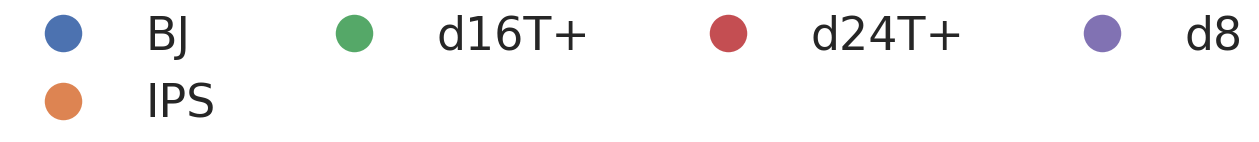

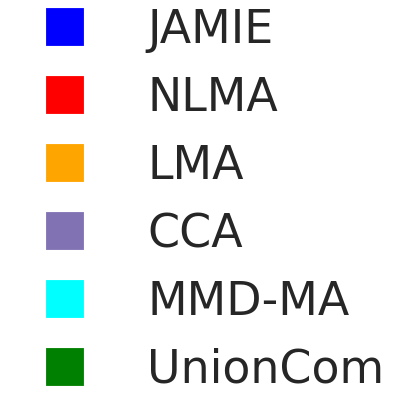

In [19]:
from IPython.display import display, Image
display( Image(filename='./output_figures/' + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename='./output_figures/' + dataset_name + '-AlgorithmLegend.png', width=100) )

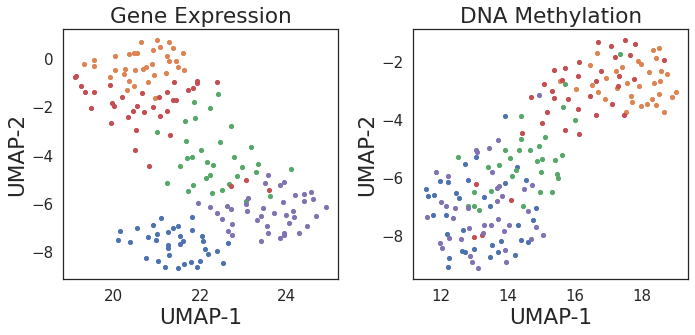

In [20]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')

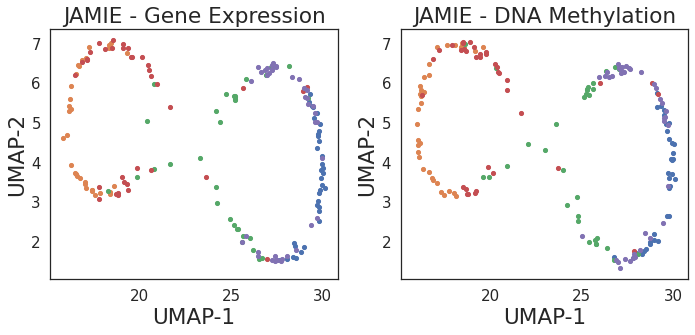

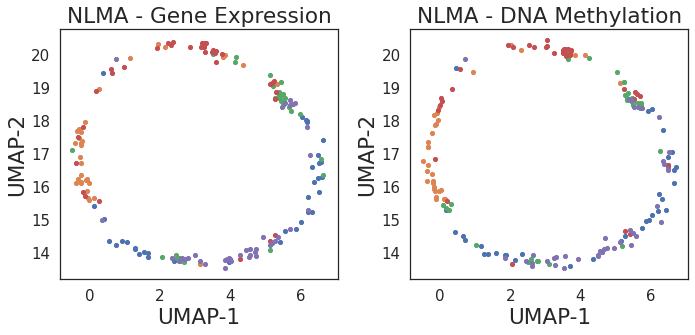

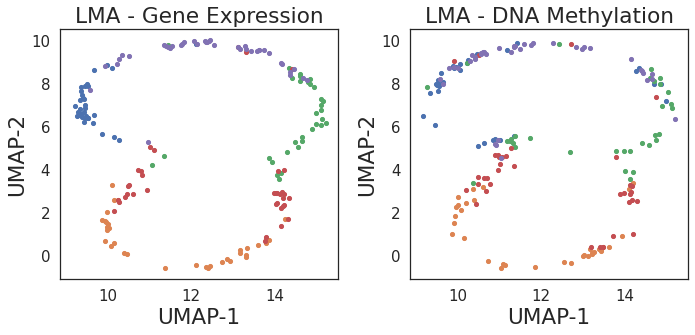

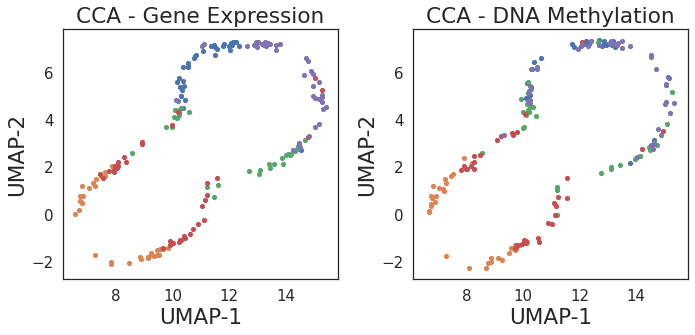

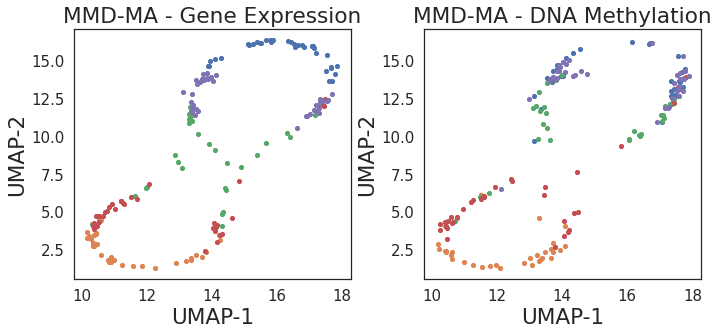

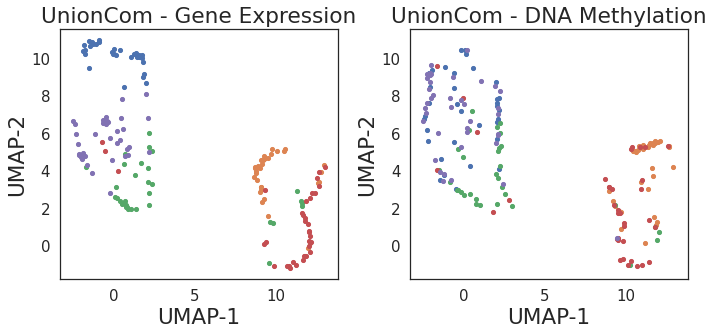

In [21]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig('./output_figures/' + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.show()

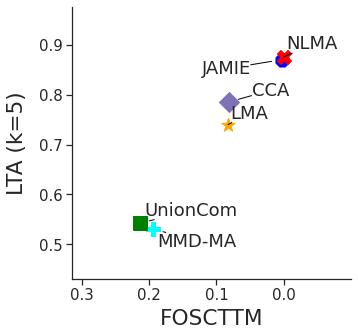

In [22]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, colors=colors, shapes=shapes)
plt.savefig('./output_figures/' + dataset_name + '-Acc.png', dpi=300, bbox_inches='tight')

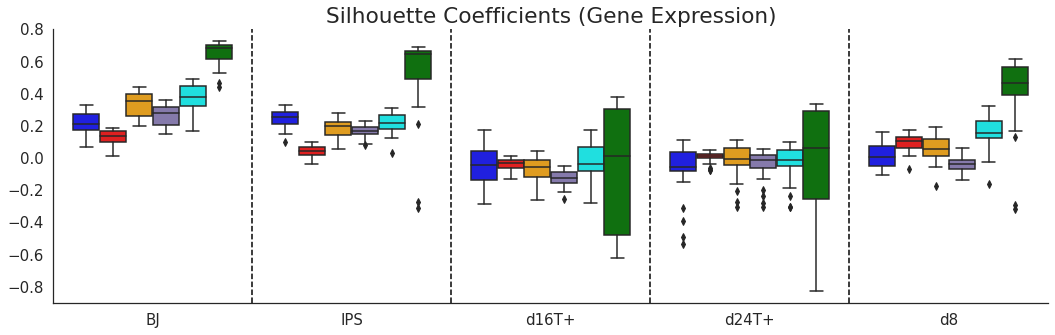

In [23]:
plt.figure(figsize=(15, 5))
plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png', dpi=300, bbox_inches='tight')

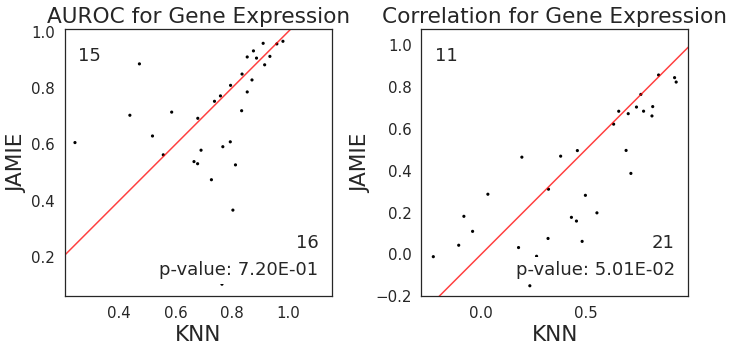

In [24]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')

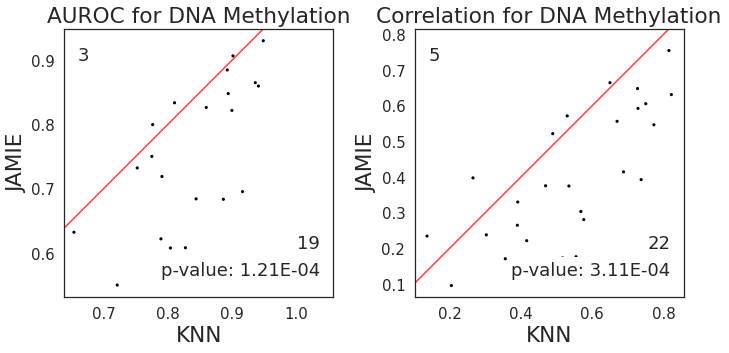

In [25]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


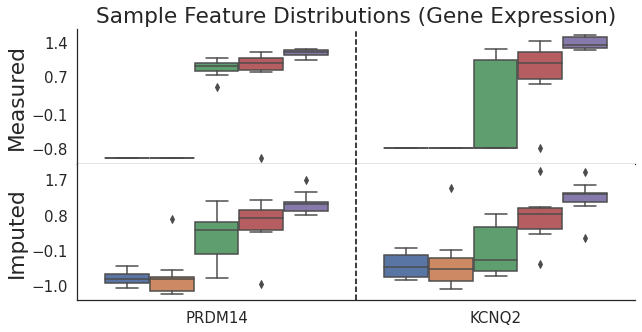

In [26]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], cm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')

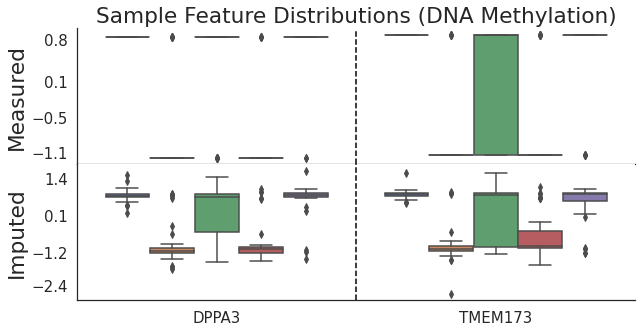

In [27]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1], cm_imputed[1]], 2*[labels[1]], title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict)
sns.despine()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')

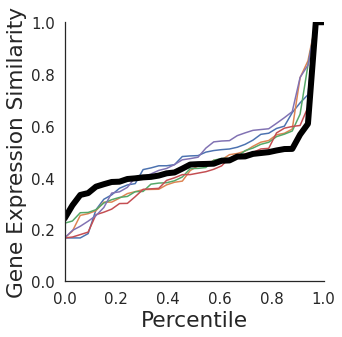

In [28]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')

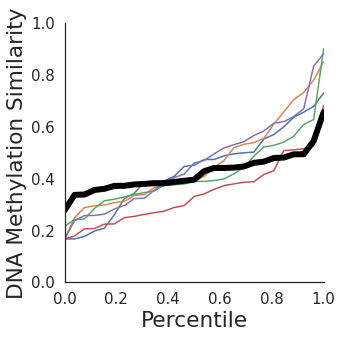

In [29]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1][test_idx]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')

# Explanation

In [30]:
mod0, mod1 = 0, 1
current_cm = cm
analysis_str = f'output_data/JAMIE---{size_str}---sorted_genes'

In [31]:
target_name = 'LTA'
testing_idx = np.array(range(dataset[mod0].shape[1]))
# function = lambda x: current_cm.test_LabelTA(2*[current_cm.transform_one(x, mod0)], labels)
Ly = current_cm.transform_one(dataset[mod1], mod1)
function = lambda x: current_cm.test_LabelTA([current_cm.transform_one(x, mod0), Ly], labels)
perf_function = lambda x: x

if not os.path.exists(analysis_str):
    baseline, performance = evaluate_impact(function, perf_function, dataset[mod0][:, testing_idx], features[mod0])
    argsort = np.argsort(performance)
    sorted_idx = testing_idx[argsort]
    sorted_names = features[mod0][sorted_idx]
    sorted_names = np.array([s.replace(' ', '_') for s in sorted_names])
    sorted_perf = performance[argsort]
    
    file_contents = np.concatenate([sorted_idx.reshape((-1, 1)), sorted_names.reshape((-1, 1)), sorted_perf.reshape((-1, 1))], axis=1)
    file_contents_str = '\n'.join([' '.join([str(s) for s in r]) for r in file_contents]) + '\n'
    with open(analysis_str, 'w') as f:
        f.write(file_contents_str)
else:
    baseline = perf_function(function(dataset[mod0]))
    sorted_idx = []
    sorted_names = []
    sorted_perf = []
    with open(analysis_str, 'r') as f:
        for line in f:
            idx, names, perf = line[:-1].split(' ')
            sorted_idx.append(int(idx))
            sorted_names.append(str(names))
            sorted_perf.append(float(perf))
    sorted_idx, sorted_names, sorted_perf = np.array(sorted_idx), np.array(sorted_names), np.array(sorted_perf)
    performance = sorted_perf

/mnt/c/Users/nck/repos/nmacom/commando/utilities.py:568: RuntimeWarning: invalid value encountered in true_divide
  out = out / self.sample.std(self.axis)


In [32]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {target_name}')
print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={target_name}')
importance = sorted_names[:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n, p in zip(importance, sorted_perf[:display]):
    print(f'{p:.5f}: https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target DNA Methylation Feature: LTA
https://www.genecards.org/cgi-bin/carddisp.pl?gene=LTA
Important Gene Expression Features: MYC, FOSL1, TFAP2A, TGFBR2, HAND1, NESTIN, LUM, JARID2, AFP, DNMT3L, CDX2, DAZL, NKX2-5, IGF2, TBX3, WNT10B, CER1, FGF4, LEFTY, OCT4
0.22599: https://www.genecards.org/cgi-bin/carddisp.pl?gene=MYC
0.27119: https://www.genecards.org/cgi-bin/carddisp.pl?gene=FOSL1
0.28249: https://www.genecards.org/cgi-bin/carddisp.pl?gene=TFAP2A
0.29944: https://www.genecards.org/cgi-bin/carddisp.pl?gene=TGFBR2
0.29944: https://www.genecards.org/cgi-bin/carddisp.pl?gene=HAND1
0.29944: https://www.genecards.org/cgi-bin/carddisp.pl?gene=NESTIN
0.30508: https://www.genecards.org/cgi-bin/carddisp.pl?gene=LUM
0.30508: https://www.genecards.org/cgi-bin/carddisp.pl?gene=JARID2
0.31073: https://www.genecards.org/cgi-bin/carddisp.pl?gene=AFP
0.31073: https://www.genecards.org/cgi-bin/carddisp.pl?gene=DNMT3L
0.31638: https://www.genecards.org/cgi-bin/carddisp.pl?gene=CDX2
0.31638: https:/

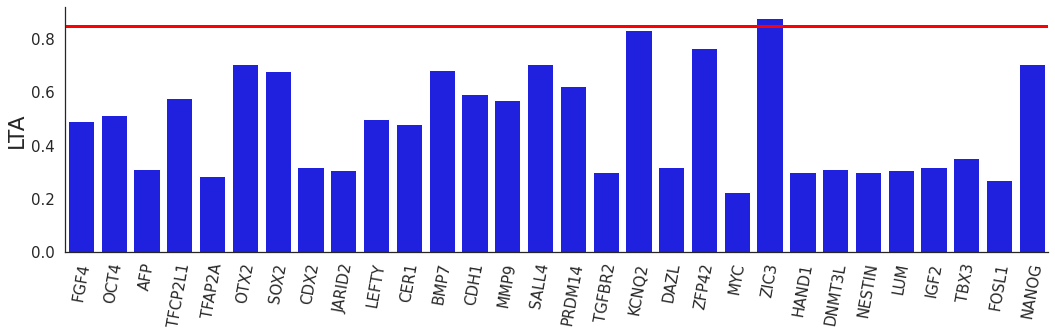

In [33]:
plt.figure(figsize=(15, 5))
plot_impact(sorted_perf, sorted_names, baseline, max_features=30, color=dataset_color)
sns.despine()
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Analysis.png', dpi=300, bbox_inches='tight')

# SHAP

In [34]:
# RNA (Place) -> ATAC
# ENSG00000251562 (4) -> HYLS1
# ENSG00000251562 (4) -> HYLS1

# ATAC (Place) -> RNA
# ANKRD16 -> ENSG00000138119
# PWWP2B

In [35]:
# import shap

# # Subset for runtime
# use_subsetting = True
# subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
# background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
# def take_subset(x, do=use_subsetting):
#     if not do:
#         return x
#     if len(x.shape) == 1:
#         return x[subset_idx]
#     return x[:, subset_idx]
# def reverse_subset(x, do=use_subsetting):
#     if not do:
#         return x
#     new_vec = np.concatenate(x.shape[0] * [background], axis=0)
#     new_vec[:, subset_idx] = x
#     return new_vec

# target_feature = interest[0]
# model = lambda x: current_cm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
# data = dataset[mod0]
# back = background
# feature_names = features[mod0]
# output_names = features[mod1][target_feature]

# # Apply subsetting
# data = take_subset(data)
# back = take_subset(back)
# feature_names = list(take_subset(np.array(feature_names)))

# # Explainer
# explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names)
# shap_values = explainer(data, max_evals=2*data.shape[1]+1)

In [36]:
# display = 20
# print(f'Target {modality_names[mod1]} Feature: {output_names}')
# for n in [output_names]:
#     print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
# importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:display]
# # importance = np.array(shap_values.feature_names)[np.argsort(shap_values.mean(axis=0).abs.values)[::-1][:display]]
# # importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.max(axis=0).abs.values)[::-1][:display]]
# imp_str = ', '.join(importance)
# print(f'Important {modality_names[mod0]} Features: {imp_str}')
# for n in importance:
#     print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

In [37]:
# plt.figure(figsize=(10, 5))
# ax = plt.gcf().add_subplot(1, 1, 1)
# shap.summary_plot(shap_values, data, plot_type='violin', max_display=display, plot_size=(9.2, 5), show=False)
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

In [38]:
# plt.figure(figsize=(10, 5))
# shap.plots.heatmap(shap_values, max_display=7, show=False)  # 7 because problem with visualization and tight layout
# plt.gca().set_xlabel('Samples')
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

In [39]:
# plt.figure(figsize=(10, 5))
# ax = plt.gcf().add_subplot(1, 1, 1)
# shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

In [40]:
# plt.figure(figsize=(10, 5))
# ax = plt.gcf().add_subplot(1, 1, 1)
# shap.plots.waterfall(100*shap_values[0], show=False)
# plt.tight_layout()
# plt.savefig('./output_figures/' + dataset_name + '-Waterfall1.png');

## Interactive

In [41]:
# # Kernel Explainer
# kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     kshap_values = kexplainer.shap_values(data, nsamples=100)

In [42]:
# shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
# plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [43]:
# shap.initjs()
# shap.force_plot(kexplainer.expected_value, kshap_values, data)